### Predicting On Base Probabilities for MLB
Prepared by: David L. Parks  
January 20, 2022

#### Introduction

The goal of this project is to predict the probability of a single, double, triple, and home run for each row in the test.csv dataset. We will train a Logistic Regression classification model using cross-validated grid searching to find the optimal solver for the model. The resulting model will be employed against the test.csv dataset.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# set options
pd.options.display.max_columns = 30
pd.options.display.max_rows = 500
sns.set()

In [2]:
# load the data files
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# take an initial look at the train dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26417 entries, 0 to 26416
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BATTER_UID                 26417 non-null  int64  
 1   AVG                        26417 non-null  float64
 2   OBP                        26417 non-null  float64
 3   SLG                        26417 non-null  float64
 4   VENUE_KEY                  26417 non-null  int64  
 5   OUTS                       26417 non-null  int64  
 6   BALLS                      26417 non-null  int64  
 7   STRIKES                    26417 non-null  int64  
 8   BATS_LEFT                  26417 non-null  int64  
 9   THROWS_LEFT                26417 non-null  int64  
 10  PITCH_NUMBER               26417 non-null  int64  
 11  RELEASE_SPEED              26417 non-null  float64
 12  PLATE_X                    26417 non-null  float64
 13  PLATE_Z                    26417 non-null  flo

In [4]:
train_data.describe()

,BATTER_UID,AVG,OBP,SLG,VENUE_KEY,OUTS,BALLS,STRIKES,BATS_LEFT,THROWS_LEFT,PITCH_NUMBER,RELEASE_SPEED,PLATE_X,PLATE_Z,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,EXIT_SPEED,ANGLE,DIRECTION,PA,1B,2B,3B,HR
count,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.00000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.000000,26417.0,26417.000000,26417.000000,26417.000000,26417.000000
mean,77.083166,0.266509,0.338621,0.421516,3511.394594,0.961994,1.097399,1.087141,0.40879,0.257675,3.374077,88.070399,-0.004379,2.390453,8.406908,-2.251175,-6.464524,0.708558,87.845587,11.891719,-1.411950,1.0,0.221486,0.078737,0.008366,0.055646
std,46.535376,0.025537,0.029151,0.060953,1057.965718,0.815085,1.009314,0.815168,0.49162,0.437362,1.815762,5.973575,0.549463,0.564997,8.310898,9.981369,1.459043,1.912473,14.478576,26.771236,25.222521,0.0,0.415255,0.269333,0.091083,0.229241
min,2.000000,0.185000,0.257000,0.288000,2528.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,37.449699,-3.467520,-0.531748,-23.053499,-28.636900,-21.713999,-8.191260,6.246275,-86.351218,-179.200520,1.0,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.252333,0.321000,0.377000,2745.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,83.901894,-0.387697,2.001010,3.195120,-10.629300,-7.353590,-0.432960,79.669640,-5.907461,-18.366974,1.0,0.000000,0.000000,0.000000,0.000000
50%,77.000000,0.267000,0.338000,0.412500,2843.000000,1.000000,1.000000,1.000000,0.00000,0.000000,3.000000,89.118103,0.001932,2.383280,9.548400,-3.430170,-6.259550,0.850877,90.774180,13.003828,-1.583680,1.0,0.000000,0.000000,0.000000,0.000000
75%,118.000000,0.286000,0.358000,0.454500,4669.000000,2.000000,2.000000,2.000000,1.00000,1.000000,5.000000,92.710304,0.377295,2.768060,15.099000,5.691090,-5.395020,2.050800,98.596160,29.526086,15.205374,1.0,0.000000,0.000000,0.000000,0.000000
max,157.000000,0.333000,0.444000,0.613000,5472.000000,2.000000,4.000000,3.000000,1.00000,1.000000,14.000000,102.254005,2.947300,5.011410,55.518299,25.942999,-2.365730,7.025000,138.596393,89.381098,179.257979,1.0,1.000000,1.000000,1.000000,1.000000


Note that there doesn't appear to be any NULL entries or extreme outliers in the train dataset.

In [5]:
# take an initial look at the test dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9310 entries, 0 to 9309
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BATTER_UID                 9310 non-null   int64  
 1   AVG                        9310 non-null   float64
 2   OBP                        9310 non-null   float64
 3   SLG                        9310 non-null   float64
 4   VENUE_KEY                  9310 non-null   int64  
 5   OUTS                       9310 non-null   int64  
 6   BALLS                      9310 non-null   int64  
 7   STRIKES                    9310 non-null   int64  
 8   BATS_LEFT                  9310 non-null   int64  
 9   THROWS_LEFT                9310 non-null   int64  
 10  PITCH_NUMBER               9310 non-null   int64  
 11  RELEASE_SPEED              9310 non-null   float64
 12  PLATE_X                    9310 non-null   float64
 13  PLATE_Z                    9310 non-null   float

In [6]:
test_data.describe()

,BATTER_UID,AVG,OBP,SLG,VENUE_KEY,OUTS,BALLS,STRIKES,BATS_LEFT,THROWS_LEFT,PITCH_NUMBER,RELEASE_SPEED,PLATE_X,PLATE_Z,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE
count,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000
mean,80.504296,0.271136,0.342181,0.424237,3514.624490,0.951128,1.092589,1.042213,0.552309,0.271429,3.315145,88.087218,-0.012048,2.379362,8.436633,-2.585158,-6.465088,0.640945
std,43.721795,0.023922,0.025454,0.045694,1030.844157,0.813911,1.011917,0.820592,0.497283,0.444721,1.822838,6.017945,0.544385,0.570937,8.282195,10.112506,1.469475,1.866616
min,0.000000,0.211000,0.290500,0.361000,2528.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.084099,-2.590670,-1.625220,-22.654900,-31.106798,-19.385399,-7.078670
25%,45.000000,0.261000,0.325333,0.389333,2767.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,83.985596,-0.380536,1.982927,3.344552,-11.156075,-7.346182,-0.470687
50%,82.000000,0.273000,0.344000,0.413333,2844.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,89.122501,-0.013048,2.374315,9.536220,-4.058435,-6.275880,0.755758
75%,122.000000,0.289000,0.360500,0.453000,4271.000000,2.000000,2.000000,2.000000,1.000000,1.000000,4.000000,92.765524,0.364860,2.755872,15.150750,5.677157,-5.409073,1.961847
max,152.000000,0.319500,0.384000,0.555000,5472.000000,2.000000,3.000000,2.000000,1.000000,1.000000,12.000000,101.850998,2.886620,5.212350,42.796101,23.431599,-2.249530,6.715640


Note that there doesn't appear to be any NULL entries or extreme outliers in the train dataset. However, the test dataset does not contain EXIT_SPEED, ANGLE, DIRECTION or any of the outcome columns.

#### Data Exploration

Before we prepare the train dataset for modeling, let's consolidate the bases columns into a single outcome column and take a look at the distributions of the EXIT_SPEED, ANGLE, and DIRECTION columns relative to the new outcome column.

In [7]:
# copy the original train dataset so it is not modified
train_2 = train_data.copy()

# remove duplicate rows
train_2.drop_duplicates(inplace=True, ignore_index=True)

# consolidate the bases columns into a single outcome column where
# 0 = no base
# 1 = single
# 2 = double
# 3 = triple
# 4 = home run
train_2["OUTCOME"] = train_2['1B'] + (train_2['2B'] * 2) + (train_2['3B'] * 3) + (train_2['HR'] * 4) 

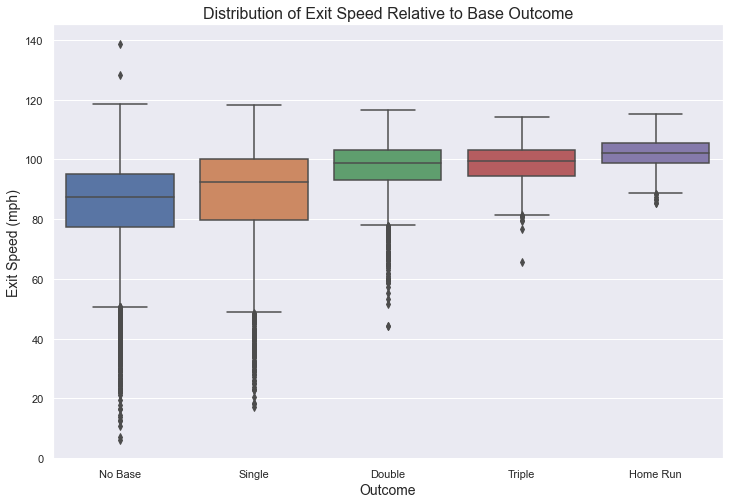

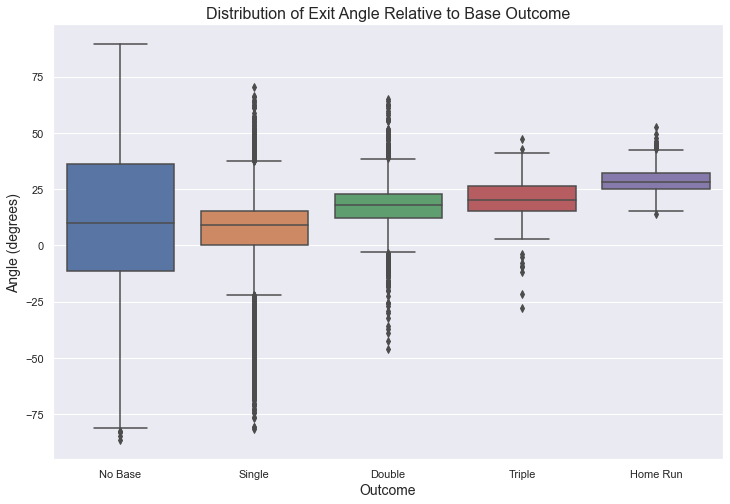

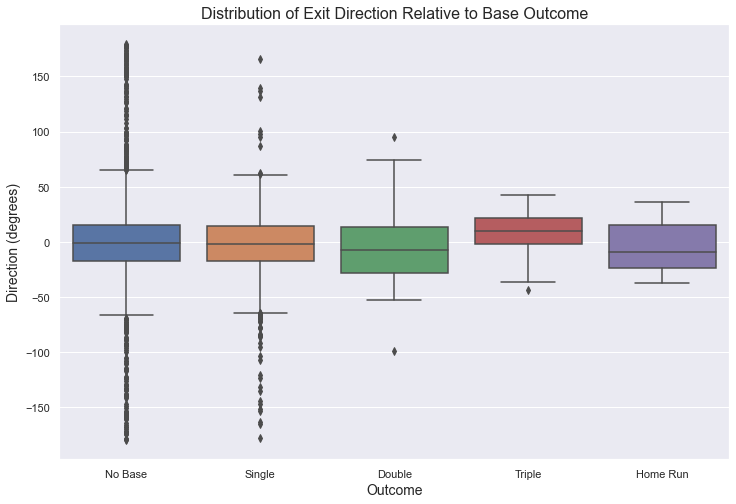

In [8]:
# create boxplots for EXIT_SPEED, ANGLE, and DIRECTION relative to outcome
outcome_labels = ["No Base", "Single", "Double", "Triple", "Home Run"]

plt.figure(figsize=(12, 8))
sns.boxplot(x=train_2.OUTCOME, y=train_2.EXIT_SPEED)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=outcome_labels)
plt.xlabel("Outcome", size=14)
plt.ylabel("Exit Speed (mph)", size=14)
plt.title("Distribution of Exit Speed Relative to Base Outcome", size=16)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x=train_2.OUTCOME, y=train_2.ANGLE)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=outcome_labels)
plt.xlabel("Outcome", size=14)
plt.ylabel("Angle (degrees)", size=14)
plt.title("Distribution of Exit Angle Relative to Base Outcome", size=16)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x=train_2.OUTCOME, y=train_2.DIRECTION)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=outcome_labels)
plt.xlabel("Outcome", size=14)
plt.ylabel("Direction (degrees)", size=14)
plt.title("Distribution of Exit Direction Relative to Base Outcome", size=16)
plt.show()

Looking at the boxplots, we definitely see a consistent pattern from left to right as the outcomes transition from No Base to Home Run. The exit speed becomes higher and the exit angle and exit direction become more consistent. Even though these features won't be used as input for modeling, they deserve further consideration since these attributes are coachable.

To get a sense of the probabilities that our model should predict, we compute some descriptive statistics for On Base Percent (OBP) and the base outcomes. Using this information, we will determine, on average, how often a player gets on base and, given that a player gets on base, how often we should expect them to get a single, double, triple, or home run.

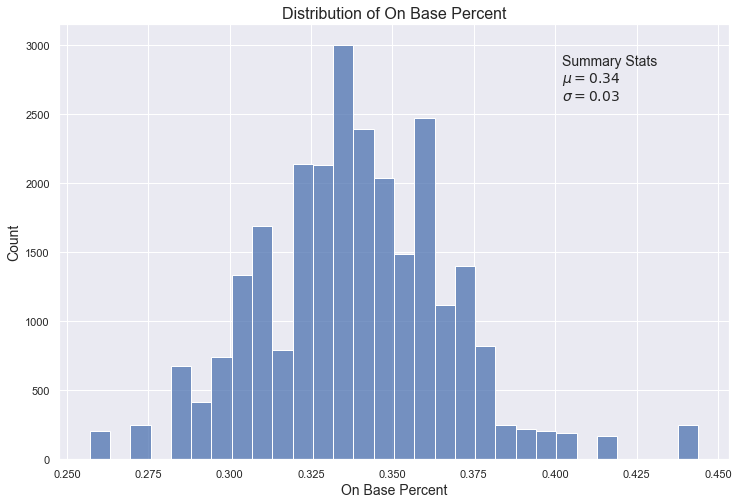

In [9]:
# compute the mean and standard deviation for OBP
mean_obp = train_2.OBP.mean()
sd_obp = train_2.OBP.std()

textstr = '\n'.join(("Summary Stats", r'$\mu=%.2f$' % (mean_obp, ), r'$\sigma=%.2f$' % (sd_obp, )))

# create a histogram for OBP with mean and standard deviation
plt.figure(figsize=(12, 8))
sns.histplot(train_2.OBP, bins=30)
plt.xlabel("On Base Percent", size=14)
plt.ylabel("Count", size=14)
plt.title("Distribution of On Base Percent", size=16)
plt.text(0.402, 2600, s=textstr, fontsize=14);

We see from the distribution plot above that OBP appears to be normally distributed and that mean OBP = 0.34, meaning that the average player gets on base approximately 34% of the time.

We can further isolate the events that we are interested in predicting - single, double, triple, and home run - and plot them as a percentage of getting on base.

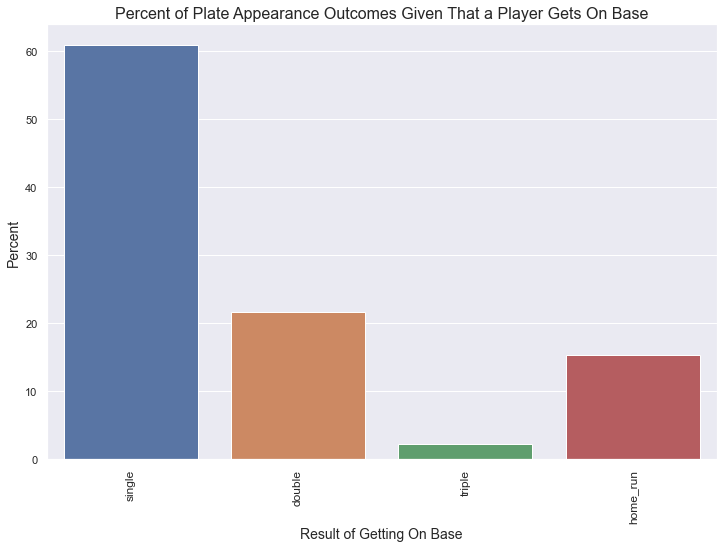

In [10]:
# plot the base outcomes as a percentage of getting on base
pct_bases = train_2.EVENT_RESULT_KEY.value_counts()[['single', 'double', 'triple', 'home_run']] / sum(train_2.EVENT_RESULT_KEY.value_counts()[['single', 'double', 'triple', 'home_run']])
pct_bases = round(pct_bases * 100, 2)

plt.figure(figsize=(12,8))
sns.barplot(x=pct_bases.index, y=pct_bases.values)
plt.xticks(rotation=90, size=12)
plt.xlabel("Result of Getting On Base", size=14)
plt.ylabel("Percent", size=14)
plt.title("Percent of Plate Appearance Outcomes Given That a Player Gets On Base", size = 16);

We see from the plot above that given a player gets on base, we would expect that player to single about 61% , double 22%, triple 2%, and hit a home run 15% of the time. Using the average OBP and the percentages listed above, we can calculate the conditional probability of each base outcome.

<center>Single: 0.34 * 0.61 = 0.2</center>  
<center>Double: 0.34 * 0.22 = 0.08</center>  
<center>Triple: 0.34 * 0.02 = 0.007</center>  
<center>Home Run: 0.34 * 0.15 = 0.05</center>

We will use this information to make sure that our model passes the "common sense" test, since we expect the model's mean predicted probabilities to be similar to those we just computed manually.

#### Data Cleaning and Feature Engineering

In this section, we remove any unwanted columns, separate the dataset into training and validation sets, and process the data for modeling.

In [11]:
# remove unwanted columns
train_2 = train_2.drop(columns=['BATTER_UID', 'EXIT_SPEED', 'ANGLE', 'DIRECTION',
                                'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY', 'PA',
                                '1B', '2B', '3B', 'HR'])

# create stratified training and validation sets
# stratify using the OUTCOME column to ensure that our datasets
# have an equal distribution of outcomes and set the random_state
# to ensure reproducibility
X_train, X_val, y_train, y_val = train_test_split(train_2.iloc[:, :-1], train_2.iloc[:, -1],
                                                  train_size=0.8, stratify=train_2.OUTCOME,
                                                  random_state=39)

# create separate lists of feature names to assist with processing
num_attrib = ['AVG', 'OBP', 'SLG', 'RELEASE_SPEED', 'PLATE_X', 'PLATE_Z',
              'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'VERTICAL_APPROACH_ANGLE',
              'HORIZONTAL_APPROACH_ANGLE']
cat_attrib = ['VENUE_KEY']
remainder = ['OUTS', 'BALLS', 'STRIKES', 'BATS_LEFT', 'THROWS_LEFT', 'PITCH_NUMBER']

# create a column transformer that will standardize the numerical
# columns and create dummy variables for the VENUE_KEY column
# note that one venue key was dropped to avoid the dummy variable trap
transformers = ColumnTransformer([
    ('num', StandardScaler(), num_attrib),
    ('cat', OneHotEncoder(drop=[2683]), cat_attrib)],
     remainder='passthrough')

# fit_transform the features without saving the output
transformers.fit_transform(X_train)

# get the list of categorical feature names from the transformer
enc_cat_features = transformers.named_transformers_['cat'].get_feature_names_out()

# assemble the full list of feature names
labels = np.concatenate([num_attrib, enc_cat_features, remainder])

# transform the training and validation data and reassemble them into dataframes
X_train_trans = pd.DataFrame(transformers.transform(X_train), columns=labels)
X_val_trans = pd.DataFrame(transformers.transform(X_val), columns=labels)

# view the transformed training dataframe
X_train_trans

,AVG,OBP,SLG,RELEASE_SPEED,PLATE_X,PLATE_Z,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,VENUE_KEY_2528,VENUE_KEY_2529,VENUE_KEY_2541,VENUE_KEY_2542,VENUE_KEY_2724,...,VENUE_KEY_3970,VENUE_KEY_4271,VENUE_KEY_4669,VENUE_KEY_4670,VENUE_KEY_4715,VENUE_KEY_5355,VENUE_KEY_5410,VENUE_KEY_5421,VENUE_KEY_5472,OUTS,BALLS,STRIKES,BATS_LEFT,THROWS_LEFT,PITCH_NUMBER
0,1.194562,-0.363564,1.382590,-1.454988,-0.659978,-2.189682,-0.219826,1.513493,-1.611804,-1.135014,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0
1,1.409914,0.581257,0.693842,1.446979,0.032276,-0.664824,0.814827,-0.732842,0.492318,-0.057695,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0
2,-0.841494,-1.943993,-0.872240,0.751946,1.206324,-0.478500,1.249618,-0.356697,-0.166634,0.389421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0
3,0.156956,-0.208957,-0.683655,0.759316,0.493382,1.246128,0.719158,1.514814,0.897474,-0.689210,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,-0.554371,0.117436,-1.148297,0.202240,0.770253,-0.346877,0.901797,-0.983024,0.480993,0.224800,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,0.137379,0.323579,-1.192016,0.545819,-0.093947,0.102375,-0.356214,-0.969676,0.919622,0.487651,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,3.0
21116,-0.097551,0.014364,1.726964,0.245936,0.918966,0.073790,-0.178327,1.413461,0.347865,-0.759434,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,1.0,6.0
21117,-0.704452,-0.896100,-1.019829,-0.015385,0.675402,-1.173518,0.551914,-0.823314,-0.387404,0.235854,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0
21118,-0.234593,-0.999172,-0.224489,0.092583,-0.711401,-1.566186,0.769665,-0.559952,-0.580735,-0.195893,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Modeling

The Logistic Regression model is trained using a 5-fold cross-validated grid search to find the optimal solver and then validated with data the model has not seen. An accuracy score, classification report, and confusion matrix are created using the validation set to evaluate the model's performance on unseen data. We'll also take the mean of the model's predicted probabilities and compare them to our manual calculations.

In [12]:
# define a function that plots a labeled confusion matrix 
def plot_confusion_matrix(y_actual, y_pred, labels):
    # get the confusion matrix data
    matrix = confusion_matrix(y_actual, y_pred)

    # build the plot
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='d',
                cmap=plt.cm.Oranges, linewidths=0.2)
    x_ticks = np.arange(len(labels)) + 0.5
    y_ticks = x_ticks
    plt.xticks(x_ticks, labels, rotation=0)
    plt.yticks(y_ticks, labels, rotation=0)
    plt.xlabel("Predicted", size=16)
    plt.ylabel("Actual", size=16)
    plt.title("Confusion Matrix", size=16)
    plt.show();

Logistic Regressor

In [13]:
# set up a parameter grid for grid search
search_grid = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

# instantiate a Logistic Regressor
log_reg = LogisticRegression(max_iter=1000)

# instantiate a GridSearchCV
grid_search = GridSearchCV(log_reg, search_grid,
                           cv=5, n_jobs=6,
                           scoring='neg_log_loss')

# conduct a grid search
grid_search.fit(X_train_trans, y_train)

# get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_val_trans)

# get the predicted probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_val_trans)

# calculate the accuracy score
print("Accuracy: {}".format(accuracy_score(y_val, y_pred).round(4)))

# print the classification report
print(classification_report(y_val, y_pred, zero_division=0))

Accuracy: 0.6358
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3357
           1       0.00      0.00      0.00      1169
           2       0.00      0.00      0.00       416
           3       0.00      0.00      0.00        44
           4       0.00      0.00      0.00       294

    accuracy                           0.64      5280
   macro avg       0.13      0.20      0.16      5280
weighted avg       0.40      0.64      0.49      5280



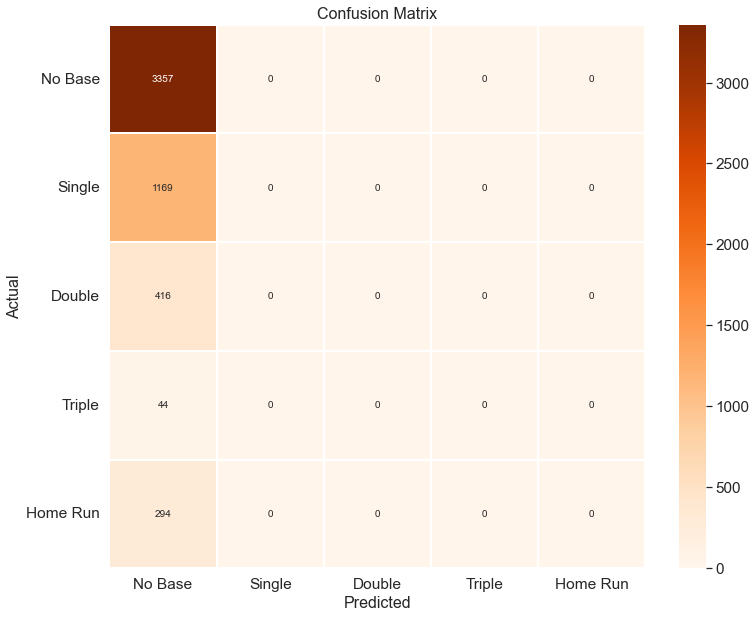

In [14]:
# plot a confusion matrix
plot_confusion_matrix(y_val, y_pred, outcome_labels)

In [15]:
# get the mean probability of each predicted outcome
y_prob.mean(axis=0).round(4)

array([0.6354, 0.2217, 0.0791, 0.0083, 0.0555])

At first glance, it appears that something is wrong with the model, it's always predicting "No Base". However, knowing that the model's *predict* method always selects the highest probability from the available choices, this is the behavior that we expect given that "No Base" always has the highest probability. When we compare the model's mean predicted probabilites to the ones we computed by hand, we see that, on average, the model's predicted probabilities are also what we expect.

|        | No Base |  Single  |  Double  |  Triple  | Home Run |
|--------|---------|----------|----------|----------|----------|
| Manual | 0.66    | 0.21     | 0.08     | 0.007    | 0.05     |
| Model  | 0.63    | 0.22     | 0.08     | 0.008    | 0.06     |

#### Employ the Final Model

Before we employ the final model on the test.csv dataset, we need to train a newly instantiated model on the full training dataset using the optimal solver that we found in the previous step. Once this is accomplished, we use the model to get the predicted probabilities for each row in the test.csv dataset and concatenate the probabilities for single, double, triple, and home run to the test.csv dataset.

In [16]:
# copy the original test dataset
test_2 = test_data.copy()

# remove the BATTER_UID column from the test dataset
test_2.drop(columns='BATTER_UID', inplace=True)

# transform the test dataset
test_2_trans = pd.DataFrame(transformers.transform(test_2), columns=labels)

In [17]:
# train a new model using the optimal solver on the full training set
full_train = pd.DataFrame(transformers.transform(train_2.iloc[:, :-1]), columns=labels)

# instantiate a Logistic Regressor
log_reg = LogisticRegression(max_iter=1000, solver=grid_search.best_params_['solver'])

# train the model on the full training set
log_reg.fit(full_train, train_2.iloc[:, -1])

# use the model to get the predicted probabilities for the test dataset
test_prob = log_reg.predict_proba(test_2_trans)

In [18]:
# drop the No Base column from the predicted probabilities
# and put the results in a dataframe
prob_df = pd.DataFrame(test_prob[:, 1:], columns=["SINGLE", "DOUBLE", "TRIPLE", "HOME_RUN"])

# concatenate the results to the original test dataset
test_modified = pd.concat([test_data, prob_df.round(4)], axis=1)

# view the test_modified dataframe
test_modified

,BATTER_UID,AVG,OBP,SLG,VENUE_KEY,OUTS,BALLS,STRIKES,BATS_LEFT,THROWS_LEFT,PITCH_NUMBER,RELEASE_SPEED,PLATE_X,PLATE_Z,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,SINGLE,DOUBLE,TRIPLE,HOME_RUN
0,81,0.2610,0.3285,0.3655,2528,2,1,2,1,0,6,89.335800,-0.384400,2.530500,16.408499,-4.477510,-4.957750,2.421590,0.1791,0.0833,0.0159,0.0423
1,125,0.2295,0.3255,0.4005,2683,1,1,1,1,0,3,87.974236,0.595641,2.485661,0.621934,-1.303324,-7.055572,2.367589,0.2467,0.1019,0.0131,0.0612
2,21,0.2745,0.3365,0.4425,2724,2,2,0,0,0,3,90.379700,-0.074184,2.732740,15.175799,-1.611590,-5.580090,2.571330,0.2034,0.0640,0.0044,0.0970
3,73,0.2890,0.3810,0.3740,2772,1,0,1,1,1,2,80.515602,0.350665,1.272440,11.282700,13.452300,-7.813180,-0.765851,0.2657,0.0817,0.0253,0.0209
4,142,0.3195,0.3605,0.4435,5472,0,0,1,1,0,2,84.069168,1.080449,1.934018,-3.228554,11.446440,-8.635422,3.918451,0.2882,0.0551,0.0065,0.0189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9305,66,0.2770,0.3475,0.4255,2745,2,0,0,0,0,1,91.087997,-0.718638,2.284420,17.801100,-11.277200,-5.530300,1.157710,0.1903,0.0817,0.0052,0.0696
9306,66,0.2770,0.3475,0.4255,2745,2,3,2,0,0,7,76.639702,0.608119,3.011990,-13.457999,14.276299,-8.634240,3.571550,0.1969,0.0520,0.0084,0.0578
9307,84,0.2670,0.3825,0.3890,2823,2,0,2,1,1,3,81.610100,-0.084573,2.411910,1.928370,-7.738690,-6.716240,-3.700070,0.2185,0.0617,0.0057,0.0258
9308,98,0.2965,0.3840,0.5270,4715,1,0,1,1,0,2,82.663994,-0.730847,2.717340,4.688830,-15.903399,-6.468180,-0.262440,0.2009,0.0807,0.0084,0.0444
